# Code for visualizing patent utility and ownership

Author: Venkatesh Subramnian

Date: June 28, 2024

## Requirements for this code to work

In addition to the packages in the `requirements.txt` file, this code requires the pickle file `./data/pats_df.pkl`. I have already made this. Refer to `01_data_making.ipynb` for making this file.

You can simply collapse all code blocks and stare at visualizations. In the future, more visualizations can be made with the attributes in the collated dataset as needed. A [plotly dashboard](https://dash.plotly.com/) can also be made for interactive visualizations. 

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [68]:
with open("./data/pats_df.pkl", 'rb') as pkl_file:
    pats_df = pickle.load(pkl_file)
pats_df['cited_by'] = pats_df['cited_by'].astype(int)
pats_df['citations'] = pats_df['citations'].astype(int)

In [3]:
#From: https://www.pythonpool.com/python-code-to-convert-a-table-to-first-normal-form/
lens = list(map(len, pats_df['cpcs'].values))
cpc_df = pd.DataFrame({'patid': np.repeat(pats_df['patid'], lens), 
                       'cpcs': np.concatenate(pats_df['cpcs'].values),
                       'cpc_desc': np.concatenate(pats_df['cpc_desc'].values)})
cpc_df['cpc_len'] = list(map(len, cpc_df.cpcs))
cpc_df['cpc_desc'] = cpc_df['cpc_desc'].apply(lambda x: ";\n".join(list(map(str.capitalize, x.split(';')))) if pd.notna(x) else x)

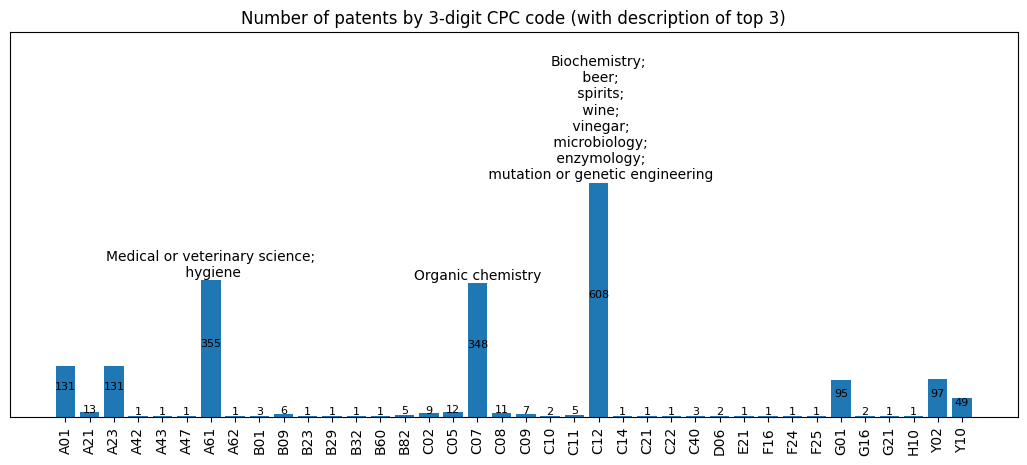

In [4]:
cpc3_df = cpc_df.loc[cpc_df['cpc_len']==3,]
plt_df = cpc3_df.groupby('cpcs').agg({'patid':'nunique'}).reset_index()
sorted_plt_df = plt_df.sort_values('patid', ascending=False)
top3_cpc = sorted_plt_df[0:3]['cpcs']
top3_cpc_df = pd.merge(sorted_plt_df, cpc3_df.loc[cpc3_df.cpcs.isin(top3_cpc), ['cpcs', 'cpc_desc']].drop_duplicates())

fig, ax = plt.subplots()
ax.bar('cpcs', 'patid', data=plt_df)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Number of patents by 3-digit CPC code (with description of top 3)')
ax.get_yaxis().set_visible(False)
ax.set_ylim(0, 1000)
ax.get_figure().set_size_inches(13, 5)
for cpc, patid, desc in zip(top3_cpc_df['cpcs'].values, top3_cpc_df['patid'].values, top3_cpc_df['cpc_desc'].values):
    ax.text(cpc, patid+10, desc, ha='center')
for cpc, patid in zip(plt_df['cpcs'].values, plt_df['patid'].values):
    ax.text(cpc, patid/2,  patid, ha="center", va="bottom", color='black', fontsize=8)

plt.show()

fig.set_size_inches(14, 6.5)

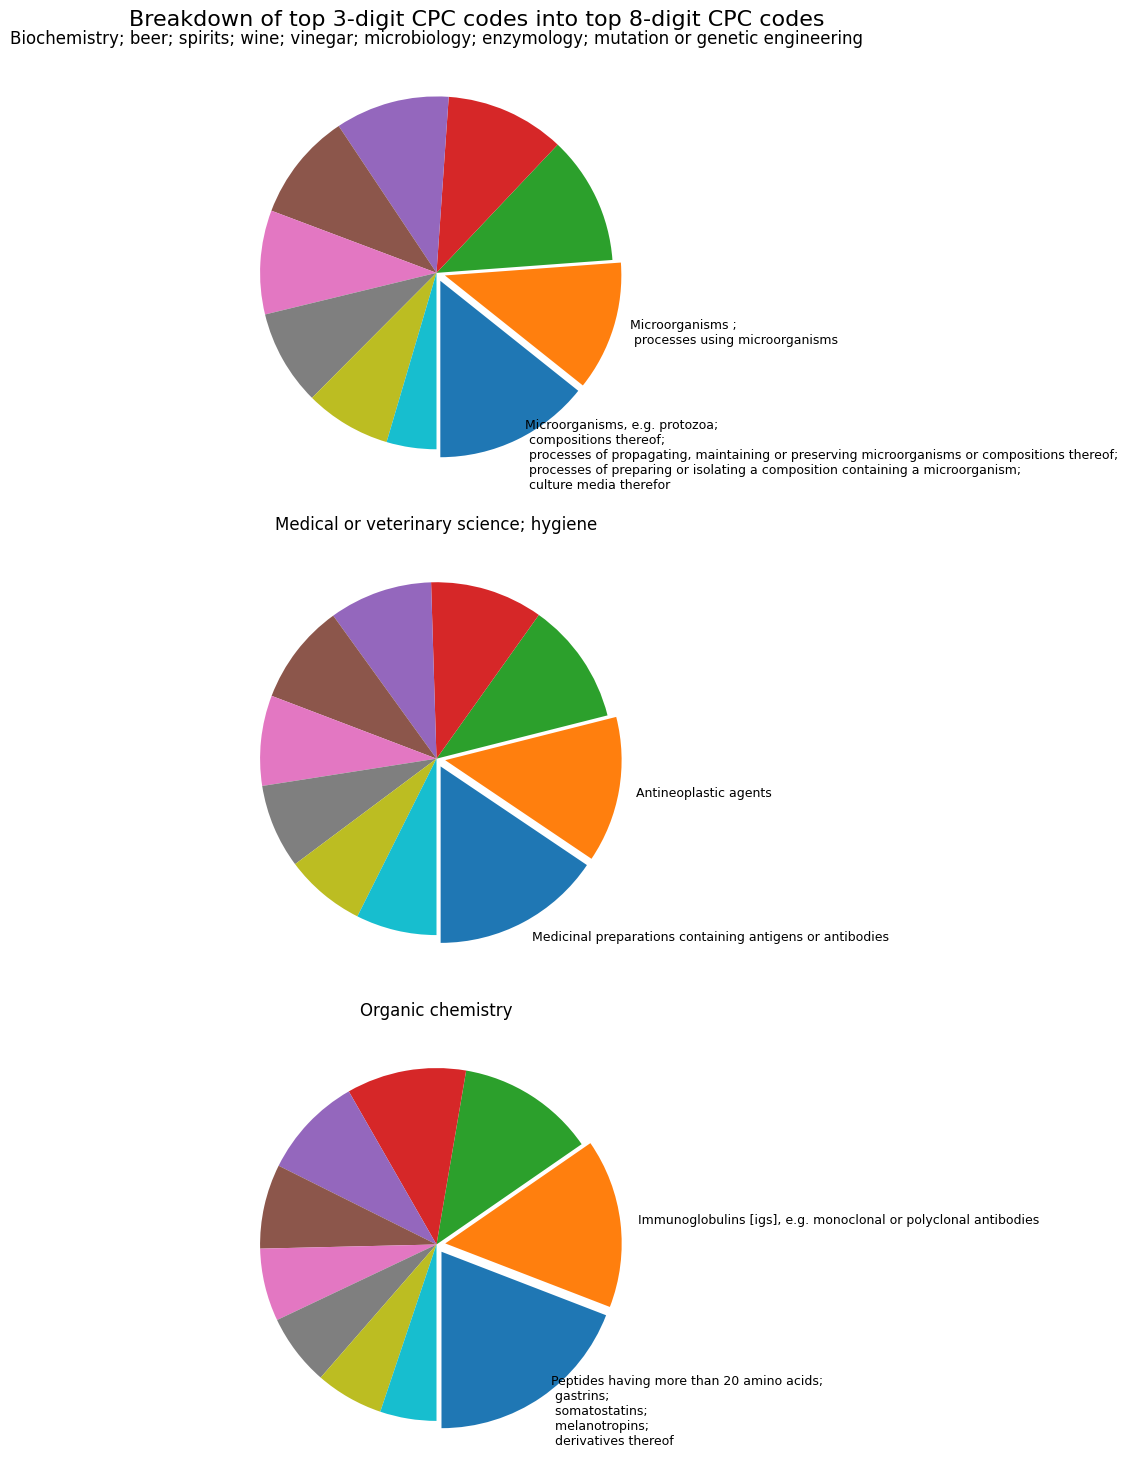

In [20]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(15, 15)
topn_labels = 2
explosion=0.05
code_size=8
for idx in range(3):
    subcpc_df = cpc_df.loc[(cpc_df['cpc_len']>=code_size) & (cpc_df['cpcs'].str.contains(top3_cpc_df['cpcs'][idx])),]
    plt_df = subcpc_df.groupby('cpcs').agg({'patid':'nunique'}).reset_index()
    plt_df = pd.merge(plt_df, subcpc_df[['cpcs', 'cpc_desc']], on='cpcs').drop_duplicates().sort_values('patid', ascending=False)[0:10]
    labels = list(plt_df['cpc_desc'][0:topn_labels])
    labels.extend(['']*(len(plt_df)-topn_labels))
    explodes = [explosion]*topn_labels
    explodes.extend([0]*(len(plt_df)-topn_labels))
    wedges = ax[idx].pie(plt_df['patid'], startangle=-90, labels=labels, textprops={'fontsize': 9}, explode = explodes)
    ax[idx].set_title(top3_cpc_df['cpc_desc'][idx].replace("\n", ""), fontsize=12)
fig.suptitle(f"Breakdown of top 3-digit CPC codes into top {code_size}-digit CPC codes", fontsize=16)
plt.tight_layout()
plt.show()

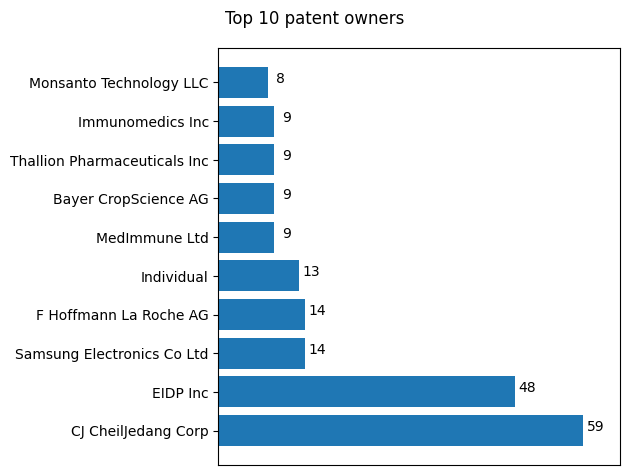

In [45]:
plt_df = pats_df.groupby('cur_assignee').agg({'patid':'nunique'}).sort_values('patid', ascending=False)[0:10].reset_index()

fig, ax = plt.subplots()
ax.barh('cur_assignee', 'patid', data=plt_df)
ax.get_xaxis().set_visible(False)
for assignee, patid in zip(plt_df['cur_assignee'].values, plt_df['patid'].values):
    ax.text(patid+2, assignee, patid, ha="center", color='black', fontsize=10)
ax.set_xlim(0, 65)
fig.suptitle("Top 10 patent owners")
plt.tight_layout()
plt.show()